In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.utils.data as data
from PIL import Image

/home/victor/codes/python_env/virtualenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"GPU is available with {num_gpus} device(s).")
    
    # Get the name of the current GPU
    current_gpu = torch.cuda.get_device_name(0)  # Assuming the first GPU is used
    print(f"Current GPU: {current_gpu}")
else:
    print("GPU is not available. Using CPU.")

GPU is available with 1 device(s).
Current GPU: NVIDIA GeForce GTX 1660


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the first available GPU
else:
    device = torch.device("cpu")  # If no GPU is available, use CPU

In [105]:
class SolarPanelDataset(data.Dataset):
    def __init__(self, img_dir, image_shape=(3, 256, 256)):
        self.image_shape = image_shape
        self.img_dir = img_dir
        self.labels = []
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.dataset_size = len(os.listdir(img_dir))
        ds_size = int(self.dataset_size/15)
        self.images = np.zeros((ds_size, *self.image_shape), dtype=np.float32)
        for i, img_name in enumerate(os.listdir(img_dir)[0:ds_size]):
            img_path = os.path.join(img_dir, img_name)
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            self.images[i] = image/255.
            label = img_name.split('_')[11]
            self.labels.append(label)  # Add corresponding label here

    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        image = self.images[idx]
        return image

In [106]:
dataset = SolarPanelDataset('/run/media/victor/victor/cv_project/SolarPanelSoilingImageDataset/Solar_Panel_Soiling_Image_dataset/PanelImages')


In [107]:
len(dataset)

3050

In [114]:
#train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [115]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 3, 3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Encode the input image
        encoded = self.encoder(x)

        # Reconstruct the original image from the compressed representation
        reconstructed = self.decoder(encoded)

        return reconstructed

In [116]:
autoencoder = Autoencoder()
autoencoder = autoencoder.to(device)

In [117]:
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [118]:
autoencoder.train()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Sigmoid()
  )
)

In [120]:
for epoch in range(1):
    for i, images in enumerate(train_dataloader):

        images = images.to(device)
        # Reconstruct the images
        reconstructions = autoencoder(images)

        # Calculate the loss
        loss = loss_function(reconstructions, images)

        print('aaa')
        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('bbb')

        # Print the loss
        if i % 100 == 0:
            print('Epoch: {}/10, Iteration: {}/{} Loss: {}'.format(epoch, i, len(train_dataloader), loss.item()))

aaa
bbb
Epoch: 0/10, Iteration: 0/96 Loss: 1.028418046189472e-05
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb


In [29]:
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [30]:
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Sigmoid()
  )
)

In [31]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [32]:
for test_batch, _ in test_dataloader:
    test_batch = test_batch.to(device)
    predicted_image_batch = autoencoder(test_batch)
    encoded_batch = autoencoder.encoder(test_batch)
    break

In [33]:

def tensor_to_image(tensor):

    """
    Converts a tensor to an image.

    Args:
        tensor: A tensor of shape (C, H, W).

    Returns:
        An image.
    """

    image = tensor.cpu().detach().numpy()
    image = image.transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    image = (image * 255).astype('uint8')  # Convert pixel values from [0, 1] to [0, 255]

    return image


In [34]:
predicted_image_batch[0].size()

torch.Size([3, 32, 32])

In [35]:
torch.mean(encoded_batch[2].transpose(0, 1).transpose(0,2),dim=1).unsqueeze(0).size()

torch.Size([1, 16, 16])

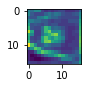

In [36]:
plt.figure(figsize=(1, 1))
plt.imshow(tensor_to_image(torch.mean(encoded_batch[5].transpose(0, 1).transpose(0,2),dim=1).unsqueeze(0)))
plt.show()

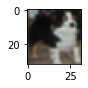

In [42]:
plt.figure(figsize=(1, 1))
plt.imshow(tensor_to_image(predicted_image_batch[3]))
plt.show()

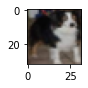

In [41]:
plt.figure(figsize=(1, 1))
plt.imshow(tensor_to_image(test_batch[3]))
plt.show()